In [ ]:
# python

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [2]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../

cp references/detection/transforms.py ../

cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:
# 导入库
import zipfile
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from PIL import Image
import pycocotools
import pandas as pd
import os
import torchvision

In [ ]:
os.chdir("/content")

In [ ]:
# 读取边框数据
labels = pd.read_csv("/content/shiplabels.csv")
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,boat0.png,466,418,boat,282,205,333,273
1,boat1.png,400,362,boat,194,128,266,185
2,boat1.png,400,362,boat,169,170,189,187
3,boat10.png,400,243,boat,236,19,249,32
4,boat10.png,400,243,boat,244,68,253,83


In [ ]:
labels = pd.read_csv("/content/raccoon_dataset/data/raccoon_labels.csv")
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-1.jpg,650,417,raccoon,81,88,522,408
1,raccoon-10.jpg,450,495,raccoon,130,2,446,488
2,raccoon-100.jpg,960,576,raccoon,548,10,954,520
3,raccoon-101.jpg,640,426,raccoon,86,53,400,356
4,raccoon-102.jpg,259,194,raccoon,1,1,118,152


In [ ]:
# 返回图像中物体的边框，每个边框包含四个参数，分别是左下角和右上角的x轴和y轴的坐标
def parse_one_annot(path_to_data_file, filename):
  data = pd.read_csv(path_to_data_file)
  boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
   "xmax", "ymax"]].values
   
  return boxes_array

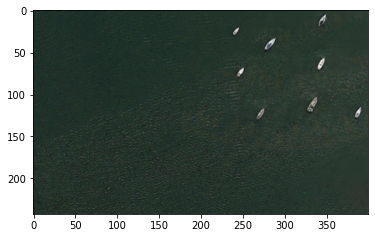

In [ ]:
# 举例，说明parse_one_annot函数的返回值,和csv文件中坐标的意义
img = cv2.imread("/content/images/boat10.png")
img_rgb = img[:,:,::-1] # 将图像转换为RGB
plt.imshow(img_rgb)
plt.show()

In [ ]:
# 上图中有8个白色船只，都是需要检测到的物体，因此返回8*4的数组，表示图中8个船只的边框位置
parse_one_annot("/content/shiplabels.csv", "boat10.png")

array([[236,  19, 249,  32],
       [244,  68, 253,  83],
       [276,  33, 290,  52],
       [341,   6, 351,  22],
       [340,  58, 350,  73],
       [327, 103, 341, 124],
       [266, 117, 278, 133],
       [384, 115, 394, 131]])

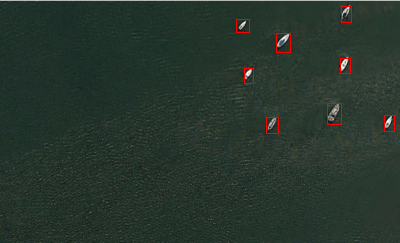

In [ ]:
image = Image.open("/content/images/boat10.png")
draw = ImageDraw.Draw(image)
coordinates = parse_one_annot("/content/shiplabels.csv", "boat10.png")
for i in coordinates:
  draw.rectangle([(i[0], i[1]), (i[2], i[3])], outline ="red")
image

In [ ]:
# 将图像和csv文件中边框坐标的数据一一对应
# ???RaccoonDataset要改成boatdataset
class RaccoonDataset(torch.utils.data.Dataset):
  def __init__(self, root, data_file, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = sorted(os.listdir(os.path.join(root, "images")))
    self.path_to_data_file = data_file
  
  def __getitem__(self, idx):
    # load images and bounding boxes
    img_path = os.path.join(self.root, "images", self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    box_list = parse_one_annot(self.path_to_data_file, 
    self.imgs[idx])
    boxes = torch.as_tensor(box_list, dtype=torch.float32)
    num_objs = len(box_list)
      # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,
      0])
      # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd
    if self.transforms is not None:
      img, target = self.transforms(img, target)
    
    return img, target
  
  def __len__(self):
    return len(self.imgs)

In [ ]:
# 以上一张图像boat10.png为例，看输出结果
dataset = RaccoonDataset(root= '/content',data_file= "/content/shiplabels.csv")
dataset.__getitem__(2)

(<PIL.Image.Image image mode=RGB size=400x243 at 0x7FDE225A2390>,
 {'area': tensor([169., 135., 266., 160., 150., 294., 192., 160.]),
  'boxes': tensor([[236.,  19., 249.,  32.],
          [244.,  68., 253.,  83.],
          [276.,  33., 290.,  52.],
          [341.,   6., 351.,  22.],
          [340.,  58., 350.,  73.],
          [327., 103., 341., 124.],
          [266., 117., 278., 133.],
          [384., 115., 394., 131.]]),
  'image_id': tensor([2]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1])})

In [ ]:
def get_model(num_classes):
  # load an object detection model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
   # replace the pre-trained head with a new on
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
  return model

In [ ]:
def get_transform(train):
  transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
  transforms.append(T.ToTensor())
  if train:
    # during training, randomly flip the training images
      # and ground-truth for data augmentation
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = RaccoonDataset(root= "/content",
          data_file= "/content/shiplabels.csv",
          transforms = get_transform(train=True))
dataset_test = RaccoonDataset(root= "/content",
               data_file= "/content/shiplabels.csv",
               transforms = get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-186])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-186:])


In [ ]:
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4,
         collate_fn=utils.collate_fn)
print("数据集共包含: {} 张图像; 训练集: {} 张; 测试集: {} 张".format(len(indices), len(dataset), len(dataset_test)))

数据集共包含: 621 张图像; 训练集: 435 张; 测试集: 186 张


In [ ]:
torch.cuda.is_available()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only - raccoon and not racoon
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [ ]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# let's train it for 5 epochs
num_epochs = 5
for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, data_loader, device, epoch,
                   print_freq=100)
# update the learning rate
  lr_scheduler.step()
   # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/218]  eta: 0:05:34  lr: 0.000028  loss: 0.0443 (0.0443)  loss_classifier: 0.0136 (0.0136)  loss_box_reg: 0.0301 (0.0301)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.5324  data: 0.2911  max mem: 4598
Epoch: [0]  [100/218]  eta: 0:02:38  lr: 0.002330  loss: 0.0461 (0.1145)  loss_classifier: 0.0149 (0.0295)  loss_box_reg: 0.0287 (0.0625)  loss_objectness: 0.0002 (0.0043)  loss_rpn_box_reg: 0.0007 (0.0182)  time: 1.2581  data: 0.0109  max mem: 4598
Epoch: [0]  [200/218]  eta: 0:00:23  lr: 0.004632  loss: 0.0519 (0.1061)  loss_classifier: 0.0159 (0.0271)  loss_box_reg: 0.0313 (0.0587)  loss_objectness: 0.0001 (0.0038)  loss_rpn_box_reg: 0.0013 (0.0165)  time: 1.3309  data: 0.0094  max mem: 4598
Epoch: [0]  [217/218]  eta: 0:00:01  lr: 0.005000  loss: 0.0607 (0.1039)  loss_classifier: 0.0189 (0.0267)  loss_box_reg: 0.0406 (0.0583)  loss_objectness: 0.0001 (0.0036)  loss_rpn_box_reg: 0.0007 (0.0153)  time: 1.2824  data: 0.0090  max mem: 4598


In [ ]:
# let's train it for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, data_loader, device, epoch,
                   print_freq=100)
# update the learning rate
  lr_scheduler.step()
   # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/218]  eta: 0:06:22  lr: 0.000028  loss: 0.3934 (0.3934)  loss_classifier: 0.1598 (0.1598)  loss_box_reg: 0.2306 (0.2306)  loss_objectness: 0.0015 (0.0015)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 1.7568  data: 0.4598  max mem: 3687
Epoch: [0]  [100/218]  eta: 0:02:34  lr: 0.002330  loss: 0.1098 (0.2834)  loss_classifier: 0.0371 (0.0811)  loss_box_reg: 0.0793 (0.1461)  loss_objectness: 0.0029 (0.0360)  loss_rpn_box_reg: 0.0009 (0.0202)  time: 1.2971  data: 0.0107  max mem: 4598
Epoch: [0]  [200/218]  eta: 0:00:23  lr: 0.004632  loss: 0.1384 (0.2690)  loss_classifier: 0.0358 (0.0717)  loss_box_reg: 0.0661 (0.1241)  loss_objectness: 0.0167 (0.0465)  loss_rpn_box_reg: 0.0018 (0.0267)  time: 1.3250  data: 0.0098  max mem: 4598
Epoch: [0]  [217/218]  eta: 0:00:01  lr: 0.005000  loss: 0.0917 (0.2633)  loss_classifier: 0.0240 (0.0697)  loss_box_reg: 0.0508 (0.1211)  loss_objectness: 0.0047 (0.0443)  loss_rpn_box_reg: 0.0018 (0.0282)  time: 1.2621  data: 0.0096  max mem: 4598


In [ ]:
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(model.state_dict())

<All keys matched successfully>

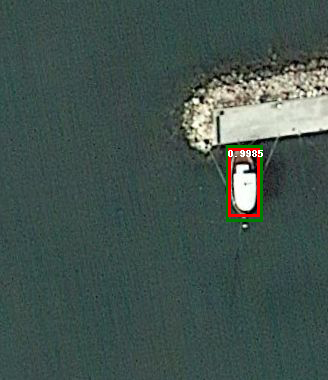

In [ ]:
idx = 2
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
# 调用训练好的模型的参数，观测其检测物体的效果
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)

# 画出真实边框和预测边框
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image